In [9]:
# Step 1: Import and Load Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
)
import matplotlib.pyplot as plt

# Load data
patients = pd.read_csv("patients.csv")
encounters = pd.read_csv("encounters.csv")
conditions = pd.read_csv("conditions.csv")

print("Data loaded:")
print(f"patients: {patients.info()}")
print(f"encounters: {encounters.info()}")
print(f"conditions: {conditions.info()}")


Data loaded:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   8071 non-null   object 
 1   BIRTHDATE            8071 non-null   object 
 2   DEATHDATE            1030 non-null   object 
 3   SSN                  8071 non-null   object 
 4   DRIVERS              6681 non-null   object 
 5   PASSPORT             6288 non-null   object 
 6   PREFIX               6482 non-null   object 
 7   FIRST                8071 non-null   object 
 8   MIDDLE               6557 non-null   object 
 9   LAST                 8071 non-null   object 
 10  SUFFIX               102 non-null    object 
 11  MAIDEN               2181 non-null   object 
 12  MARITAL              5421 non-null   object 
 13  RACE                 8071 non-null   object 
 14  ETHNICITY            8071 non-null   object 
 15  GENDER               8071

In [10]:
# Step 2: Create Readmission Feature
inpatient = encounters[encounters["ENCOUNTERCLASS"] == "inpatient"].copy()

# Convert START and STOP to datetime
inpatient["START"] = pd.to_datetime(inpatient["START"])
inpatient["STOP"] = pd.to_datetime(inpatient["STOP"])

# Sort by patient and admission date
inpatient = inpatient.sort_values(by=["PATIENT", "START"]).reset_index(drop=True)

# Compute next inpatient encounter start time
inpatient["next_start"] = inpatient.groupby("PATIENT")["START"].shift(-1)
inpatient["days_until_next"] = (inpatient["next_start"] - inpatient["STOP"]).dt.days

# Readmission if next inpatient encounter is within 30 days
inpatient["readmitted_within_30_days"] = inpatient["days_until_next"].between(0, 30)
inpatient["readmitted_within_30_days"] = inpatient["readmitted_within_30_days"].fillna(False)

# Keep only relevant columns
df = inpatient[["Id", "PATIENT", "START", "STOP", "readmitted_within_30_days"]].copy()
df.rename(columns={"Id": "ENCOUNTER_ID"}, inplace=True)

df.head()

,ENCOUNTER_ID,PATIENT,START,STOP,readmitted_within_30_days
0,000b14a9-1d2d-22f1-dbc2-75818610a510,000b14a9-1d2d-22f1-3ab4-8679696393d8,2017-09-16 01:39:11+00:00,2017-09-17 04:39:11+00:00,False
1,0015603b-aa9c-24de-3030-d50de5651439,0015603b-aa9c-24de-f3ac-eaa142b530d1,2015-01-19 09:23:46+00:00,2015-01-20 09:23:46+00:00,False
2,0030c87f-465a-bb05-dae1-33d4254fd4b0,0030c87f-465a-bb05-403f-507d300e1f6f,2023-05-30 22:40:26+00:00,2023-06-02 00:46:47+00:00,False
3,0030c87f-465a-bb05-44b2-ef524f7fdd69,0030c87f-465a-bb05-403f-507d300e1f6f,2023-06-02 00:31:47+00:00,2023-06-03 00:31:47+00:00,False
4,003e9df5-953b-701b-fb88-1deaecabae0e,003e9df5-953b-701b-5384-20b64367f236,2017-01-26 13:26:50+00:00,2017-01-29 13:26:50+00:00,False


In [11]:
# Step 3: Create num_conditions Feature
cond_counts = conditions.groupby("ENCOUNTER").size().reset_index(name="num_conditions")

# Merge with df on encounter ID
df = df.merge(cond_counts, how="left", left_on="ENCOUNTER_ID", right_on="ENCOUNTER")

# Replace missing condition counts with 0
df["num_conditions"] = df["num_conditions"].fillna(0).astype(int)

# Drop redundant column
df.drop(columns=["ENCOUNTER"], inplace=True)

df.head()


,ENCOUNTER_ID,PATIENT,START,STOP,readmitted_within_30_days,num_conditions
0,000b14a9-1d2d-22f1-dbc2-75818610a510,000b14a9-1d2d-22f1-3ab4-8679696393d8,2017-09-16 01:39:11+00:00,2017-09-17 04:39:11+00:00,False,0
1,0015603b-aa9c-24de-3030-d50de5651439,0015603b-aa9c-24de-f3ac-eaa142b530d1,2015-01-19 09:23:46+00:00,2015-01-20 09:23:46+00:00,False,1
2,0030c87f-465a-bb05-dae1-33d4254fd4b0,0030c87f-465a-bb05-403f-507d300e1f6f,2023-05-30 22:40:26+00:00,2023-06-02 00:46:47+00:00,False,0
3,0030c87f-465a-bb05-44b2-ef524f7fdd69,0030c87f-465a-bb05-403f-507d300e1f6f,2023-06-02 00:31:47+00:00,2023-06-03 00:31:47+00:00,False,0
4,003e9df5-953b-701b-fb88-1deaecabae0e,003e9df5-953b-701b-5384-20b64367f236,2017-01-26 13:26:50+00:00,2017-01-29 13:26:50+00:00,False,0


In [13]:
# Step 4: Train-test Split and Model Setup
X = df[["num_conditions"]]
y = df["readmitted_within_30_days"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [14]:
# Step 5: Model Evaluation
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Precision: 0.306
Recall:    0.985
F1 Score:  0.467
AUC:       0.699

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.41      0.58      2003
           1       0.31      0.98      0.47       525

    accuracy                           0.53      2528
   macro avg       0.65      0.70      0.53      2528
weighted avg       0.85      0.53      0.56      2528



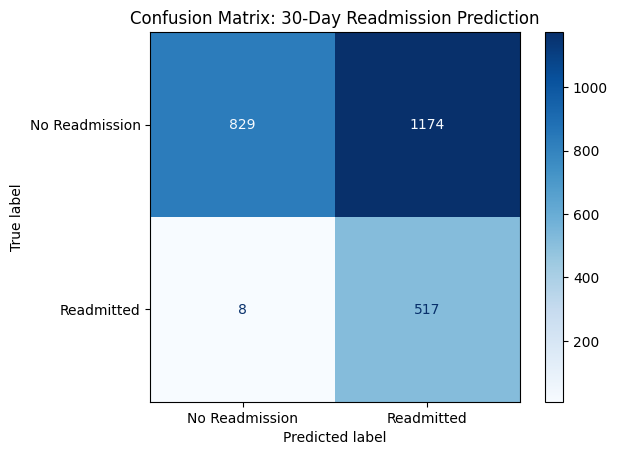

In [17]:
# Step 6: Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Readmission", "Readmitted"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: 30-Day Readmission Prediction")
plt.show()


In [15]:
# Step 7: Examine Coefficients and Odds Ratios
coef = model.coef_[0][0]
odds_ratio = pd.Series([coef]).apply(lambda c: round(np.exp(c), 3)).iloc[0]

print(f"Coefficient for num_conditions: {coef:.4f}")
print(f"Odds ratio (e^(coef)): {odds_ratio:.3f}")


Coefficient for num_conditions: -3.1568
Odds ratio (e^(coef)): 0.043


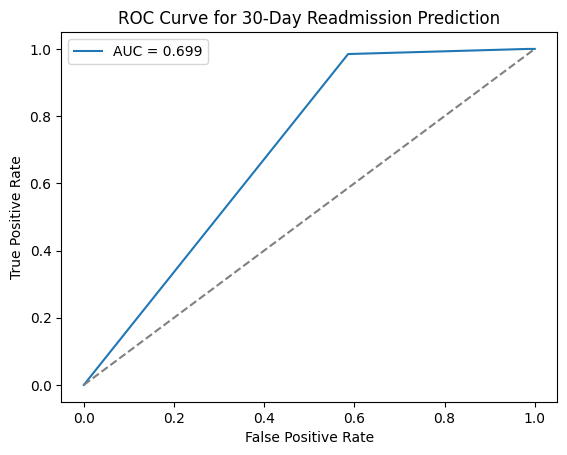

In [16]:
# Step 8: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for 30-Day Readmission Prediction")
plt.legend()
plt.show()
